# Winner Explanation


In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.profiles import Profile
from pref_voting.generate_profiles import *


Weak Condorcet winner is not Copeland winner
+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| 3 | 2 | 1 | 4 | 2 | 0 | 3 | 4 |
| 0 | 1 | 4 | 2 | 3 | 1 | 2 | 0 |
| 4 | 4 | 2 | 1 | 0 | 3 | 0 | 2 |
| 1 | 0 | 0 | 3 | 4 | 4 | 1 | 3 |
| 2 | 3 | 3 | 0 | 1 | 2 | 4 | 1 |
+---+---+---+---+---+---+---+---+


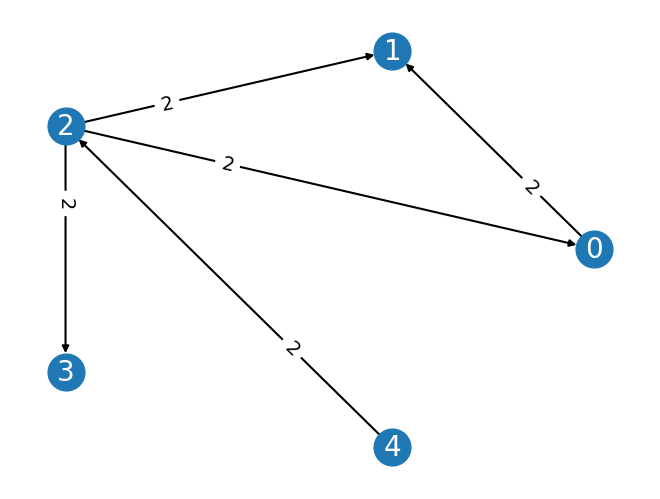

Weak Condorcet winner: [4]
Copeland winner: [2]


In [8]:
nc = 5
nv = 8
num_trials = 100000
for _ in range(num_trials): 

    prof = generate_profile(nc, nv)

    wcw = prof.weak_condorcet_winner()
    c_ws = copeland(prof)
    if wcw is not None and len(wcw) == 1 and wcw != c_ws and len(c_ws) == 1 and any([prof.margin(wcw[0], c) > 0 for c in prof.candidates]): 
        print("Weak Condorcet winner is not Copeland winner")
        print(prof)
        prof.display_margin_graph()
        print("Weak Condorcet winner:", wcw)
        print("Copeland winner:", c_ws)
        break

In [23]:
prof = Profile([
    [0, 1, 2], 
    [1, 0, 2], 
    [2, 1, 0]
], 
rcounts=[40, 15, 45])

instant_runoff.display(prof)
minimax.display(prof)

Instant Runoff winner is {0}
Minimax winner is {1}


In [3]:
def test_ballot_conversion():
    from pref_voting.profiles_with_ties import ProfileWithTies
    from collections import Counter, defaultdict
    
    # Your original profile
    a = 0
    b = 1
    c = 2
    prof = ProfileWithTies(
        candidates=[a, b, c],
        rankings=[
            {a: 1, b: 2, c: 3},  # 50: Alice > Bob > Charlie
            {b: 1, a: 2, c: 3},  # 30: Bob > Alice > Charlie
            {c: 1, a: 3},        # 10: Charlie > Alice (Bob unranked)
            {b: 1}               # 10: Bob only
        ],
        rcounts=[2, 3, 1, 1],
        cmap={a: "Alice", b: "Bob", c: "Charlie"}
    )
    
    print("ORIGINAL PROFILE:")
    prof.display()
    print(f"\nTotal voters: {prof.num_voters}")
    
    # Convert to ballot documents (simulating what backend does)
    ballot_docs = []
    rankings, counts = prof.rankings_counts
    
    for ranking, count in zip(rankings, counts):
        for _ in range(count):
            ballot_doc = {
                "rankings": []
            }

            # Get the ranking dictionary
            for candidate in ranking.cands:
                print(candidate)
                ballot_doc["rankings"].append({
                    "option_id": candidate,
                    "rank": ranking.rmap[candidate]
                })
                print(ballot_doc)
            ballot_docs.append(ballot_doc)
    
    print(f"\nConverted to {len(ballot_docs)} ballot documents")
    
    # Now convert back (this is what _create_profile_from_ballots does)
    option_id_to_candidate = {0: "C0", 1: "C1", 2: "C2"}
    
    ballot_counter = Counter()
    
    for ballot_doc in ballot_docs:
        rankings_by_rank = defaultdict(list)
        
        for ranking in ballot_doc["rankings"]:
            option_id = ranking["option_id"]
            rank = ranking["rank"]
            candidate = option_id_to_candidate[option_id]
            rankings_by_rank[rank].append(candidate)
        
        sorted_ranks = sorted(rankings_by_rank.keys())
        ranking_tuple = tuple(
            tuple(sorted(rankings_by_rank[rank])) 
            for rank in sorted_ranks
        )
        
        ballot_counter[ranking_tuple] += 1
    
    print("\nBALLOT COUNTER RESULTS:")
    for ranking_tuple, count in ballot_counter.items():
        print(f"  {ranking_tuple}: {count} votes")
    
    # Create new profile
    rankings = []
    counts = []
    
    for ranking_tuple, count in ballot_counter.items():
        ranking_dict = {}
        for rank_idx, candidates_at_rank in enumerate(ranking_tuple):
            for candidate in candidates_at_rank:
                cand_id = int(candidate[1])  # Extract number from C0, C1, C2
                ranking_dict[cand_id] = rank_idx + 1
        rankings.append(ranking_dict)
        counts.append(count)
    
    candidates = [0, 1, 2]
    reconstructed = ProfileWithTies(rankings, rcounts=counts, candidates=candidates)
    
    print("\nRECONSTRUCTED PROFILE:")
    reconstructed.display()
    print(f"\nReconstructed total voters: {reconstructed.num_voters}")
    
    if prof.num_voters != reconstructed.num_voters:
        print(f"\n🚨 ERROR: Lost {prof.num_voters - reconstructed.num_voters} voters!")
    
    # Check what's different
    print("\nCOMPARISON:")
    print("Original rankings and counts:")
    orig_rankings, orig_counts = prof.rankings_counts
    for r, c in zip(orig_rankings, orig_counts):
        print(f"  {c}: {r.rmap}")
    
    print("\nReconstructed rankings and counts:")
    recon_rankings, recon_counts = reconstructed.rankings_counts
    for r, c in zip(recon_rankings, recon_counts):
        print(f"  {c}: {r.rmap}")


test_ballot_conversion()

ORIGINAL PROFILE:
+---------+---------+---------+-----+
|    2    |    3    |    1    |  1  |
+---------+---------+---------+-----+
|  Alice  |   Bob   | Charlie | Bob |
|   Bob   |  Alice  |  Alice  |     |
| Charlie | Charlie |         |     |
+---------+---------+---------+-----+

Total voters: 7
0
{'rankings': [{'option_id': 0, 'rank': 1}]}
1
{'rankings': [{'option_id': 0, 'rank': 1}, {'option_id': 1, 'rank': 2}]}
2
{'rankings': [{'option_id': 0, 'rank': 1}, {'option_id': 1, 'rank': 2}, {'option_id': 2, 'rank': 3}]}
0
{'rankings': [{'option_id': 0, 'rank': 1}]}
1
{'rankings': [{'option_id': 0, 'rank': 1}, {'option_id': 1, 'rank': 2}]}
2
{'rankings': [{'option_id': 0, 'rank': 1}, {'option_id': 1, 'rank': 2}, {'option_id': 2, 'rank': 3}]}
0
{'rankings': [{'option_id': 0, 'rank': 2}]}
1
{'rankings': [{'option_id': 0, 'rank': 2}, {'option_id': 1, 'rank': 1}]}
2
{'rankings': [{'option_id': 0, 'rank': 2}, {'option_id': 1, 'rank': 1}, {'option_id': 2, 'rank': 3}]}
0
{'rankings': [{'option

In [4]:
"""
Standalone results calculator - just copy this into your Jupyter notebook.
No imports needed from your app!
"""

from datetime import datetime
from typing import Dict, List, Optional, Tuple
from collections import defaultdict, Counter
from pref_voting.profiles_with_ties import ProfileWithTies
from pref_voting.voting_methods import minimax, copeland
from pref_voting.margin_based_methods import minimax_scores
import json


class ResultsCalculator:
    """Standalone version of ResultsService without dependencies"""
    
    def __init__(self):
        self._candidate_to_option_id = {}
    
    def create_profile_from_ballots(self, poll, ballot_docs):
        """Convert poll and ballots to ProfileWithTies format"""
        option_id_to_candidate = {opt.id: f"C{i}" for i, opt in enumerate(poll.options)}
        
        ballot_counter = Counter()
        
        for ballot_doc in ballot_docs:
            rankings_by_rank = defaultdict(list)
            
            for ranking in ballot_doc["rankings"]:
                option_id = ranking["option_id"]
                rank = ranking["rank"]
                candidate = option_id_to_candidate[option_id]
                rankings_by_rank[rank].append(candidate)
            
            sorted_ranks = sorted(rankings_by_rank.keys())
            ranking_tuple = tuple(
                tuple(sorted(rankings_by_rank[rank])) 
                for rank in sorted_ranks
            )
            
            ballot_counter[ranking_tuple] += 1
        
        rankings = []
        counts = []
        
        for ranking_tuple, count in ballot_counter.items():
            ranking_dict = {}
            for rank_idx, candidates_at_rank in enumerate(ranking_tuple):
                for candidate in candidates_at_rank:
                    ranking_dict[candidate] = rank_idx + 1
            rankings.append(ranking_dict)
            counts.append(count)
        
        candidates = list(option_id_to_candidate.values())
        self._candidate_to_option_id = {v: k for k, v in option_id_to_candidate.items()}
        
        return ProfileWithTies(rankings, rcounts=counts, candidates=candidates)
    
    def get_condorcet_winner(self, profile, candidate_names):
        winner = profile.condorcet_winner()
        if winner is not None:
            option_id = self._candidate_to_option_id.get(winner, winner)
            return candidate_names.get(option_id, winner)
        return None
    
    def get_weak_condorcet_winners(self, profile, candidate_names):
        winners = profile.weak_condorcet_winner()
        if winners:
            named_winners = []
            for winner in winners:
                option_id = self._candidate_to_option_id.get(winner, winner)
                named_winners.append(candidate_names.get(option_id, winner))
            return named_winners
        return []
    
    def calculate_candidate_records(self, profile, candidate_names):
        copeland_scores_dict = profile.copeland_scores()
        minimax_scores_dict = minimax_scores(profile)
        
        records = []
        
        for candidate in profile.candidates:
            wins = 0
            losses = 0
            ties = 0
            opponents = []
            worst_loss_margin = None
            
            for other in profile.candidates:
                if candidate == other:
                    continue
                
                margin = profile.margin(candidate, other)
                
                if margin > 0:
                    wins += 1
                    opponents.append({
                        "opponent": candidate_names.get(self._candidate_to_option_id.get(other, other), other),
                        "result": "win",
                        "margin": margin
                    })
                elif margin < 0:
                    losses += 1
                    opponents.append({
                        "opponent": candidate_names.get(self._candidate_to_option_id.get(other, other), other),
                        "result": "loss",
                        "margin": margin
                    })
                    if worst_loss_margin is None or abs(margin) > worst_loss_margin:
                        worst_loss_margin = abs(margin)
                else:
                    ties += 1
                    opponents.append({
                        "opponent": candidate_names.get(self._candidate_to_option_id.get(other, other), other),
                        "result": "tie",
                        "margin": 0
                    })
            
            option_id = self._candidate_to_option_id.get(candidate, candidate)
            records.append({
                "candidate": candidate_names.get(option_id, candidate),
                "wins": wins,
                "losses": losses,
                "ties": ties,
                "copeland_score": float(copeland_scores_dict[candidate]),
                "minimax_score": float(minimax_scores_dict[candidate]),
                "net_wins": wins - losses,
                "opponents": opponents,
                "worst_loss_margin": worst_loss_margin if worst_loss_margin is not None else 0
            })
        
        records.sort(key=lambda r: r["copeland_score"], reverse=True)
        return records
    
    def determine_winner(self, condorcet_winner, weak_condorcet_winners, candidate_records, profile, candidate_names):
        """
        Determine the winner based on the following hierarchy:
        1. Condorcet winner (if exists)
        2. Unique weak Condorcet winner (if exists)
        3. Unique Copeland winner (best win-loss record)
        4. Unique Minimax winner (among Copeland winners)
        5. Tie (if multiple candidates remain at any level)
        """
        
        # 1. Check for Condorcet winner
        if condorcet_winner:
            return "condorcet", condorcet_winner, [], False
        
        # 2. Check for unique weak Condorcet winner
        if len(weak_condorcet_winners) == 1:
            return "weak_condorcet", weak_condorcet_winners[0], [], False
        
        # If we have multiple weak Condorcet winners or none, continue to Copeland
        
        # 3. Check Copeland scores
        if candidate_records:
            best_score = candidate_records[0]["copeland_score"]
            candidates_with_best_score = [r for r in candidate_records if r["copeland_score"] == best_score]
            
            # If unique Copeland winner
            if len(candidates_with_best_score) == 1:
                return "copeland", candidates_with_best_score[0]["candidate"], [], False
            
            # 4. Multiple candidates with same Copeland score - check minimax
            candidates_with_scores = [r for r in candidates_with_best_score if r["minimax_score"] is not None]
            
            if candidates_with_scores:
                # Higher minimax score is better (less negative = smaller worst loss)
                best_minimax_score = max(r["minimax_score"] for r in candidates_with_scores)
                minimax_winners = [r for r in candidates_with_scores if r["minimax_score"] == best_minimax_score]
                
                # If unique Minimax winner
                if len(minimax_winners) == 1:
                    return "minimax", minimax_winners[0]["candidate"], [], False
                else:
                    # 5. Multiple candidates with same minimax score - it's a tie
                    tied_candidates = [r["candidate"] for r in minimax_winners]
                    return "tie_minimax", None, tied_candidates, True
            else:
                # No minimax scores available, all candidates with best Copeland score are tied
                tied_candidates = [r["candidate"] for r in candidates_with_best_score]
                if len(tied_candidates) > 1:
                    return "tie_copeland", None, tied_candidates, True
                else:
                    return "copeland", tied_candidates[0], [], False
        
        return "none", None, [], False    
    def get_ballot_types(self, profile, candidate_names):
        ballot_types = []
        total_voters = profile.num_voters
        
        rankings, counts = profile.rankings_counts
        
        for ranking, count in zip(rankings, counts):
            ranking_list = ranking.to_indiff_list()
            
            named_ranking_list = []
            for tier in ranking_list:
                named_tier = []
                for candidate in tier:
                    option_id = self._candidate_to_option_id.get(candidate, candidate)
                    name = candidate_names.get(option_id, candidate)
                    named_tier.append(name)
                named_ranking_list.append(named_tier)
            
            ballot_types.append({
                "ranking": named_ranking_list,
                "count": count,
                "percentage": round((count / total_voters) * 100, 2)
            })
        
        ballot_types.sort(key=lambda x: x["count"], reverse=True)
        return ballot_types


def generate_test_scenario(profile, candidate_names, scenario_name, notes, expected_behavior):
    """Generate test scenario using simplified calculator"""
    from collections import namedtuple
    
    # Mock objects
    Option = namedtuple('Option', ['id', 'name'])
    Poll = namedtuple('Poll', ['id', 'options'])
    poll = Poll(
        id="test_poll",
        options=[Option(id=k, name=v) for k, v in candidate_names.items()]
    )
    
    # Convert ProfileWithTies to ballot documents
    ballot_docs = []
    rankings, counts = profile.rankings_counts
    for ranking, count in zip(rankings, counts):
        for _ in range(count):
            ballot_docs.append({
                "poll_id": "test_poll",
                "is_test": False,
                "rankings": [{"option_id": c, "rank": ranking.rmap[c]} for c in ranking.cands]
            })
    
    # Use standalone calculator
    calc = ResultsCalculator()
    
    # Calculate everything
    profile_backend = calc.create_profile_from_ballots(poll, ballot_docs)
    profile_backend.use_extended_strict_preference()
    
    candidate_names_dict = {opt.id: opt.name for opt in poll.options}
    
    condorcet_winner = calc.get_condorcet_winner(profile_backend, candidate_names_dict)
    weak_condorcet_winners = calc.get_weak_condorcet_winners(profile_backend, candidate_names_dict) if not condorcet_winner else []
    candidate_records = calc.calculate_candidate_records(profile_backend, candidate_names_dict)
    winner_type, determined_winner, tied_winners, is_tie = calc.determine_winner(
        condorcet_winner, weak_condorcet_winners, candidate_records, profile_backend, candidate_names_dict
    )
    
    # Build results (simplified - add more fields as needed)
    results = {
        "poll_id": "test_poll",
        "calculated_at": datetime.utcnow().isoformat(),
        "total_voters": profile_backend.num_voters,
        "total_ballots": len(ballot_docs),
        "num_candidates": len(profile_backend.candidates),
        "candidates": [candidate_names_dict.get(calc._candidate_to_option_id.get(c, c), c) for c in profile_backend.candidates],
        "ballot_types": calc.get_ballot_types(profile_backend, candidate_names_dict),
        "condorcet_winner": condorcet_winner,
        "weak_condorcet_winners": weak_condorcet_winners,
        "winner_type": winner_type,
        "determined_winner": determined_winner,
        "tied_winners": tied_winners,
        "is_tie": is_tie,
        "candidate_records": candidate_records,
        # Add other fields as needed...
    }
    
    # Format for TestWinnerExplanation.jsx
    test_scenario = {
        "name": scenario_name,
        "notes": notes,
        "expectedBehavior": expected_behavior,
        "results": results,
        "winner": results["determined_winner"],
        "tiedWinners": results["tied_winners"],
        "winnerType": results["winner_type"],
        "hasTie": results["is_tie"]
    }
    
    return json.dumps(test_scenario, indent=2, default=str)


def fix_for_javascript(test_json, scenario_key="condorcet"):
    """Fix JSON output to paste into TestWinnerExplanation.jsx"""
    
    # Fix the string number issue
    fixed = test_json.replace('"total_voters": "100"', '"total_voters": 100')
    
    # Add the scenario key and indent
    lines = fixed.strip().split('\n')
    
    # Remove outer braces
    if lines[0] == '{' and lines[-1] == '}':
        lines = lines[1:-1]
    
    # Add proper indentation and scenario key
    output = f"    {scenario_key}: {{\n"
    for line in lines:
        output += f"    {line}\n"
    output += "    },"
    
    print("Copy and paste this into TestWinnerExplanation.jsx:")
    print(output)




In [5]:
a = 0
b = 1
c = 2
prof = ProfileWithTies(
    candidates=[a, b, c],
    rankings=[
        {a: 1, 
         b: 2,
         c:3},
         {b:1, 
          a:2, 
          c:3}, 
          {c:1, 
           a:3},
          {b:1}
    ],
    rcounts = [50, 30, 10, 10],
    cmap = {a: "Alice", b: "Bob", c: "Charlie"},
)

prof.display()
print(prof.cmap[prof.condorcet_winner()])

output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Condorcet Winner - Clear",
    "Alice beats everyone head-to-head", 
    "Should show green bars for Alice",
)
fix_for_javascript(output, "condorcet")


+---------+---------+---------+-----+
|   50    |   30    |   10    | 10  |
+---------+---------+---------+-----+
|  Alice  |   Bob   | Charlie | Bob |
|   Bob   |  Alice  |  Alice  |     |
| Charlie | Charlie |         |     |
+---------+---------+---------+-----+
Alice
Copy and paste this into TestWinnerExplanation.jsx:
    condorcet: {
      "name": "Condorcet Winner - Clear",
      "notes": "Alice beats everyone head-to-head",
      "expectedBehavior": "Should show green bars for Alice",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-08T18:14:16.279854",
        "total_voters": 100,
        "total_ballots": 100,
        "num_candidates": 3,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
              ],
              [
                "Charlie"
 

In [6]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c, d],
    rankings=[
        {a: 1, 
         b: 2,
         c:3},
         {b:1, 
          a:2, 
          c:3}, 
          {c:1, 
           a:3},
          {b:1}, 
          {d:1, 
           a:2, 
           b:3},
           {d:1,}

    ],
    rcounts = [50, 20, 3, 2, 1, 1],
    cmap = {a: "Alice", b: "Bob", c: "Charlie", d: "David"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.cmap[prof.condorcet_winner()])

output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Condorcet Winner ",
    "Alice beats everyone head-to-head", 
    "Should show green bars for Alice",
)
fix_for_javascript(output, "condorcet2")


+---------+---------+---------+-----+-------+-------+
|   50    |   20    |    3    |  2  |   1   |   1   |
+---------+---------+---------+-----+-------+-------+
|  Alice  |   Bob   | Charlie | Bob | David | David |
|   Bob   |  Alice  |  Alice  |     | Alice |       |
| Charlie | Charlie |         |     |  Bob  |       |
|         |         |         |     |       |       |
+---------+---------+---------+-----+-------+-------+
Alice
Copy and paste this into TestWinnerExplanation.jsx:
    condorcet2: {
      "name": "Condorcet Winner ",
      "notes": "Alice beats everyone head-to-head",
      "expectedBehavior": "Should show green bars for Alice",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-08T18:14:16.896580",
        "total_voters": "77",
        "total_ballots": 77,
        "num_candidates": 4,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie",
          "David"
        ],
        "ballot_types": [
          {
 

In [7]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c, d],
    rankings=[
        {a: 1, 
         b: 2,
         c:3},
         {a:1, 
          c:2, 
          b:3}, 

    ],
    rcounts = [1, 1],
    cmap = {a: "Alice", b: "Bob", c: "Charlie", d: "David"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.cmap[prof.condorcet_winner()])

output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Condorcet Winner ",
    "Alice beats everyone head-to-head", 
    "Should show green bars for Alice",
)
fix_for_javascript(output, "condorcet3")


+---------+---------+
|    1    |    1    |
+---------+---------+
|  Alice  |  Alice  |
|   Bob   | Charlie |
| Charlie |   Bob   |
|         |         |
+---------+---------+
Alice
Copy and paste this into TestWinnerExplanation.jsx:
    condorcet3: {
      "name": "Condorcet Winner ",
      "notes": "Alice beats everyone head-to-head",
      "expectedBehavior": "Should show green bars for Alice",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-08T18:14:17.614058",
        "total_voters": "2",
        "total_ballots": 2,
        "num_candidates": 4,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie",
          "David"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
              ],
              [
                "Charlie"
              ]
            ],
            "count": 1,
            "percentage":

In [8]:
from pref_voting.generate_profiles import *
for _ in range(100): 
    prof = generate_profile(3, 4)
    if prof.condorcet_winner() is  None and len(prof.weak_condorcet_winner()) == 1: 
        prof.display()
        print(prof.weak_condorcet_winner())
        print("------")

+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 1 | 2 | 0 |
| 1 | 0 | 1 | 2 |
| 0 | 2 | 0 | 1 |
+---+---+---+---+
[2]
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 2 | 1 | 1 |
| 2 | 1 | 0 | 0 |
| 1 | 0 | 2 | 2 |
+---+---+---+---+
[1]
------


In [9]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c],
    rankings=[
        {
            a: 1,
            b: 2,
            c:3},
        {
            c:1,
            a:2, 
            b:3}, 
        {
            b:1,
            c:2, 
            a:3}, 

    ],
    rcounts = [2, 1, 1],
    cmap = {a: "Alice", b: "Bob", c: "Charlie"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Weak Condorcet Winner ",
    "Alice doesn't lose to anyone ", 
    "Should show green bars for Alice",
)
fix_for_javascript(output, "weak_condorcet")


+---------+---------+---------+
|    2    |    1    |    1    |
+---------+---------+---------+
|  Alice  | Charlie |   Bob   |
|   Bob   |  Alice  | Charlie |
| Charlie |   Bob   |  Alice  |
+---------+---------+---------+
[0]
Copy and paste this into TestWinnerExplanation.jsx:
    weak_condorcet: {
      "name": "Weak Condorcet Winner ",
      "notes": "Alice doesn't lose to anyone ",
      "expectedBehavior": "Should show green bars for Alice",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-08T18:14:20.200109",
        "total_voters": "4",
        "total_ballots": 4,
        "num_candidates": 3,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
              ],
              [
                "Charlie"
              ]
            ],
            "coun

In [10]:
from pref_voting.generate_profiles import *
for _ in range(100): 
    prof = generate_profile(3, 4)
    if prof.condorcet_winner() is  None and len(prof.weak_condorcet_winner()) > 1 and len(copeland(prof)) == 1: 
        prof.display()
        print(prof.weak_condorcet_winner())
        copeland.display(prof)
        print("------")

+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 0 | 2 |
| 2 | 1 | 1 | 1 |
| 0 | 2 | 2 | 0 |
+---+---+---+---+
[0, 1]
Copeland winner is {1}
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 1 | 2 | 0 |
| 1 | 2 | 1 | 1 |
| 2 | 0 | 0 | 2 |
+---+---+---+---+
[0, 1]
Copeland winner is {1}
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 2 | 2 |
| 0 | 2 | 1 | 0 |
| 2 | 1 | 0 | 1 |
+---+---+---+---+
[0, 2]
Copeland winner is {2}
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 0 | 2 | 2 |
| 1 | 1 | 1 | 0 |
| 2 | 2 | 0 | 1 |
+---+---+---+---+
[0, 2]
Copeland winner is {0}
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 1 | 2 | 2 |
| 1 | 2 | 0 | 1 |
| 2 | 0 | 1 | 0 |
+---+---+---+---+
[1, 2]
Copeland winner is {2}
------
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 2 | 0 | 1 |
| 2 | 1 | 1 | 0 |
| 1 | 0 | 2 | 2 |
+---+---+---+---+
[0, 1]
Copeland winner is {0}
------
+---+---+---+---+
| 1 

In [11]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c],
    rankings=[
        {
            c: 1,
            b: 2,
            a:3},
        {
            c:1,
            a:2, 
            b:3}, 
        {
            a:1,
            b:2, 
            c:3}, 

    ],
    rcounts = [1, 1, 2],
    cmap = {a: "Alice", b: "Bob", c: "Charlie"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "No (Weak) Condorcet Winner, but Copeland Winner",
    "Multiple Weak Condorcet winners, but Copeland winner is Alice", 
    "Should explain why Alice is the winner despite no (Weak) Condorcet winner",
)
fix_for_javascript(output, "copeland_winner")


+---------+---------+---------+
|    1    |    1    |    2    |
+---------+---------+---------+
| Charlie | Charlie |  Alice  |
|   Bob   |  Alice  |   Bob   |
|  Alice  |   Bob   | Charlie |
+---------+---------+---------+
[0, 2]
Copy and paste this into TestWinnerExplanation.jsx:
    copeland_winner: {
      "name": "No (Weak) Condorcet Winner, but Copeland Winner",
      "notes": "Multiple Weak Condorcet winners, but Copeland winner is Alice",
      "expectedBehavior": "Should explain why Alice is the winner despite no (Weak) Condorcet winner",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-08T18:14:23.409925",
        "total_voters": "4",
        "total_ballots": 4,
        "num_candidates": 3,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
     

In [57]:
from pref_voting.generate_profiles import *
for _ in range(10000): 
    prof = generate_profile(4, 10)
    if prof.condorcet_winner() is  None and prof.weak_condorcet_winner() is None and len(copeland(prof)) == 1: 
        prof.anonymize().display()
        print(prof.weak_condorcet_winner())
        copeland.display(prof)
        print("------")

+---+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 1 | 1 | 1 | 2 | 1 |
+---+---+---+---+---+---+---+---+
| 0 | 0 | 2 | 1 | 2 | 1 | 3 | 3 |
| 1 | 2 | 0 | 2 | 0 | 2 | 1 | 1 |
| 2 | 3 | 3 | 0 | 1 | 3 | 0 | 2 |
| 3 | 1 | 1 | 3 | 3 | 0 | 2 | 0 |
+---+---+---+---+---+---+---+---+
None
Copeland winner is {2}
------
+---+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 1 | 1 | 2 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| 3 | 1 | 0 | 3 | 3 | 2 | 1 | 0 |
| 1 | 0 | 2 | 0 | 2 | 1 | 2 | 3 |
| 0 | 3 | 3 | 1 | 1 | 0 | 3 | 2 |
| 2 | 2 | 1 | 2 | 0 | 3 | 0 | 1 |
+---+---+---+---+---+---+---+---+
None
Copeland winner is {0}
------
+---+---+---+---+---+---+---+---+
| 1 | 2 | 1 | 2 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 3 | 3 | 0 | 2 | 0 |
| 0 | 3 | 1 | 0 | 2 | 3 | 0 | 2 |
| 2 | 0 | 3 | 2 | 1 | 1 | 1 | 1 |
| 3 | 2 | 0 | 1 | 0 | 2 | 3 | 3 |
+---+---+---+---+---+---+---+---+
None
Copeland winner is {3}
------
+---+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+--

In [61]:

a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c, d],
    rankings=[
        {
    d: 1, 
    b: 2, 
    a: 3, 
    c: 4
},
{
    b: 1, 
    a: 2, 
    d: 3, 
    c: 4
},
{
    a: 1, 
    c: 2, 
    d: 3, 
    b: 4
},
{
    d: 1, 
    a: 2, 
    b: 3, 
    c: 4
},
{
    d: 1, 
    c: 2, 
    b: 3, 
    a: 4
},
{
    c: 1, 
    b: 2, 
    a: 3, 
    d: 4
},
{
    b: 1, 
    c: 2, 
    d: 3, 
    a: 4
},
{
    a: 1, 
    d: 2, 
    c: 3, 
    b: 4
},


    ],
    rcounts = [1, 1, 2, 1, 1, 2, 1, 1],
    cmap = {a: "Alice", b: "Bob", c: "Charlie", d: "David"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
print(copeland(prof))
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "No (Weak) Condorcet Winner, but Copeland Winner",
    "Multiple Weak Condorcet winners, but Copeland winner is Alice", 
    "Should explain why Alice is the winner despite no (Weak) Condorcet winner",
)
fix_for_javascript(output, "copeland_winner2")


+---------+---------+---------+---------+---------+---------+---------+---------+
|    1    |    1    |    2    |    1    |    1    |    2    |    1    |    1    |
+---------+---------+---------+---------+---------+---------+---------+---------+
|  David  |   Bob   |  Alice  |  David  |  David  | Charlie |   Bob   |  Alice  |
|   Bob   |  Alice  | Charlie |  Alice  | Charlie |   Bob   | Charlie |  David  |
|  Alice  |  David  |  David  |   Bob   |   Bob   |  Alice  |  David  | Charlie |
| Charlie | Charlie |   Bob   | Charlie |  Alice  |  David  |  Alice  |   Bob   |
+---------+---------+---------+---------+---------+---------+---------+---------+
None
[0]
Copy and paste this into TestWinnerExplanation.jsx:
    copeland_winner2: {
      "name": "No (Weak) Condorcet Winner, but Copeland Winner",
      "notes": "Multiple Weak Condorcet winners, but Copeland winner is Alice",
      "expectedBehavior": "Should explain why Alice is the winner despite no (Weak) Condorcet winner",
      "resu

In [64]:
from pref_voting.generate_profiles import *
for _ in range(10000): 
    prof = generate_profile(4, 7)
    if prof.condorcet_winner() is  None and prof.weak_condorcet_winner() is None and len(copeland(prof)) >  1 and len(minimax(prof)) == 1: 
        prof.anonymize().display()
        print(prof.weak_condorcet_winner())
        copeland.display(prof)
        minimax.display(prof)
        print(prof.to_profile_with_ties().description())
        print("------")

+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 1 | 1 | 2 | 0 | 2 | 3 | 0 |
| 2 | 3 | 0 | 1 | 0 | 1 | 1 |
| 0 | 2 | 3 | 3 | 1 | 2 | 2 |
| 3 | 0 | 1 | 2 | 3 | 0 | 3 |
+---+---+---+---+---+---+---+
None
Copeland winners are {0, 1, 2}
Minimax winner is {1}
ProfileWithTies([{1: 0, 2: 1, 0: 2, 3: 3}, {1: 0, 3: 1, 2: 2, 0: 3}, {2: 0, 0: 1, 3: 2, 1: 3}, {0: 0, 1: 1, 3: 2, 2: 3}, {2: 0, 0: 1, 1: 2, 3: 3}, {3: 0, 1: 1, 2: 2, 0: 3}, {0: 0, 1: 1, 2: 2, 3: 3}], rcounts=[1, 1, 1, 1, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
------
+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 0 | 2 | 3 | 2 | 0 | 3 | 3 |
| 2 | 3 | 0 | 1 | 2 | 0 | 1 |
| 3 | 1 | 1 | 3 | 1 | 2 | 0 |
| 1 | 0 | 2 | 0 | 3 | 1 | 2 |
+---+---+---+---+---+---+---+
None
Copeland winners are {0, 2, 3}
Minimax winner is {3}
ProfileWithTies([{0: 0, 2: 1, 3: 2, 1: 3}, {2: 0, 3: 1, 1: 2, 0: 3}, {3: 0, 0: 1, 1: 2, 2: 3}, {2: 0, 1: 1, 3: 2, 0: 3}, {0: 0,

In [66]:
prof = ProfileWithTies([{0: 0, 2: 1, 3: 2, 1: 3}, {3: 0, 0: 1, 1: 2, 2: 3}, {1: 0, 0: 1, 2: 2, 3: 3}, {2: 0, 3: 1, 0: 2, 1: 3}, {3: 0, 0: 1, 2: 2, 1: 3}, {2: 0, 3: 1, 1: 2, 0: 3}, {0: 0, 2: 1, 1: 2, 3: 3}], rcounts=[1, 1, 1, 1, 1, 1, 1], 
                       cmap={0: 'Alice', 1: 'Bob', 2: 'Charlie', 3: 'David'})

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
print(copeland(prof))
print(minimax(prof))
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "No (Weak) Condorcet Winner, no Copeland Winner, Minimax Winner",
    "Multiple Weak Condorcet winners, multiple Copeland winners, but Minimax winner is Alice", 
    "Should explain why Alice is the winner despite no (Weak) Condorcet winner and no unique Copeland winner",
)
fix_for_javascript(output, "minimax_winner")



+---------+---------+---------+---------+---------+---------+---------+
|    1    |    1    |    1    |    1    |    1    |    1    |    1    |
+---------+---------+---------+---------+---------+---------+---------+
|  Alice  |  David  |   Bob   | Charlie |  David  | Charlie |  Alice  |
| Charlie |  Alice  |  Alice  |  David  |  Alice  |  David  | Charlie |
|  David  |   Bob   | Charlie |  Alice  | Charlie |   Bob   |   Bob   |
|   Bob   | Charlie |  David  |   Bob   |   Bob   |  Alice  |  David  |
+---------+---------+---------+---------+---------+---------+---------+
None
[0, 2, 3]
[0]
Copy and paste this into TestWinnerExplanation.jsx:
    minimax_winner: {
      "name": "No (Weak) Condorcet Winner, no Copeland Winner, Minimax Winner",
      "notes": "Multiple Weak Condorcet winners, multiple Copeland winners, but Minimax winner is Alice",
      "expectedBehavior": "Should explain why Alice is the winner despite no (Weak) Condorcet winner and no unique Copeland winner",
      "resul

In [67]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b, c, d],
    rankings=[
        {
    a: 1, 
    b: 2, 
    c: 3, 
    d: 4
},
{
    b: 1, 
    c: 2, 
    a: 3, 
    d: 4
},
{
    c: 1, 
    a: 2, 
    b: 3, 
    d: 4
},
    ],
    rcounts = [1, 1, 1],
    cmap = {a: "Alice", b: "Bob", c: "Charlie", d: "David"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
print(copeland(prof))
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Tied winners",
    "Multiple Weak Condorcet winners/Copeland winners", 
    "Should explain why there is a tie",
)
fix_for_javascript(output, "tied_winners1")


+---------+---------+---------+
|    1    |    1    |    1    |
+---------+---------+---------+
|  Alice  |   Bob   | Charlie |
|   Bob   | Charlie |  Alice  |
| Charlie |  Alice  |   Bob   |
|  David  |  David  |  David  |
+---------+---------+---------+
None
[0, 1, 2]
Copy and paste this into TestWinnerExplanation.jsx:
    tied_winners1: {
      "name": "Tied winners",
      "notes": "Multiple Weak Condorcet winners/Copeland winners",
      "expectedBehavior": "Should explain why there is a tie",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-07T16:56:38.430199",
        "total_voters": "3",
        "total_ballots": 3,
        "num_candidates": 4,
        "candidates": [
          "Alice",
          "Bob",
          "Charlie",
          "David"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
              ],
              [
   

In [69]:
a = 0
b = 1
c = 2
d= 3
prof = ProfileWithTies(
    candidates=[a, b],
    rankings=[
        {
    a: 1, 
    b: 2, 
},
{
    b: 1, 
     a: 3, 
 },
    ],
    rcounts = [500,500],
    cmap = {a: "Alice", b: "Bob"},
)

prof.use_extended_strict_preference()
prof.display()
print(prof.weak_condorcet_winner())
print(copeland(prof))
output=generate_test_scenario(
    prof,
    prof.cmap, 
    "Tied winners",
    "Multiple Weak Condorcet winners/Copeland winners", 
    "Should explain why there is a tie",
)
fix_for_javascript(output, "tied_winners2")


+-------+-------+
|  500  |  500  |
+-------+-------+
| Alice |  Bob  |
|  Bob  | Alice |
+-------+-------+
[0, 1]
[0, 1]
Copy and paste this into TestWinnerExplanation.jsx:
    tied_winners2: {
      "name": "Tied winners",
      "notes": "Multiple Weak Condorcet winners/Copeland winners",
      "expectedBehavior": "Should explain why there is a tie",
      "results": {
        "poll_id": "test_poll",
        "calculated_at": "2025-06-07T17:44:07.350884",
        "total_voters": "1000",
        "total_ballots": 1000,
        "num_candidates": 2,
        "candidates": [
          "Alice",
          "Bob"
        ],
        "ballot_types": [
          {
            "ranking": [
              [
                "Alice"
              ],
              [
                "Bob"
              ]
            ],
            "count": 500,
            "percentage": 50.0
          },
          {
            "ranking": [
              [
                "Bob"
              ],
              [
          